# SVM

In [3]:
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [20]:
X = pd.read_table('../data/data/x_train.txt', header=None, delimiter=' ')
y = pd.read_table('../data/data/y_train.txt', header=None)
X_test_submission = pd.read_table('../data/data/x_test.txt', header=None, delimiter=' ')

# based on feature selection investigation
selected_features = [100, 101, 102, 103, 104, 105]
X = X[selected_features]
X_test_submission = X_test_submission[selected_features]

In [7]:
from sklearn.svm import SVC

def apply_optimized_svm(
        X: pd.DataFrame,
        y: pd.Series,
        X_test: pd.DataFrame,
        random_state: int = 0
) -> pd.Series:
    """
    Apply the optimized SVM model to the dataset.
    :param X: pd.DataFrame - The training dataset.
    :param y: pd.Series - The target variable.
    :param X_test: pd.DataFrame - The test dataset.
    :param random_state: int - The random state.
    :return: pd.Series - The predictions.
    """

    model = SVC(
        C=0.1,
        gamma=0.1,
        class_weight='balanced',
        kernel='rbf',
        random_state=random_state,
        probability=True
    )

    model.fit(X, y)
    return pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

In [13]:
from aml_projects.Project2.models.utils import run_experiment

normal_results = run_experiment(
    'svm_results/',
    'normal',
    apply_optimized_svm,
    X,
    y,
    selected_features,
    iterations=100
)

normal_results

[ExperimentResult(score=5681.496881496882, accuracy=0.704),
 ExperimentResult(score=5851.792828685258, accuracy=0.721),
 ExperimentResult(score=6090.836653386454, accuracy=0.734),
 ExperimentResult(score=6121.063394683027, accuracy=0.744),
 ExperimentResult(score=5942.857142857142, accuracy=0.726),
 ExperimentResult(score=5905.788423153693, accuracy=0.722),
 ExperimentResult(score=5954.308617234468, accuracy=0.715),
 ExperimentResult(score=5914.624505928854, accuracy=0.714),
 ExperimentResult(score=5914.228456913826, accuracy=0.726),
 ExperimentResult(score=6120.0, accuracy=0.732),
 ExperimentResult(score=5980.0, accuracy=0.713),
 ExperimentResult(score=6175.745526838967, accuracy=0.732),
 ExperimentResult(score=6040.663900414938, accuracy=0.738),
 ExperimentResult(score=5991.919191919193, accuracy=0.732),
 ExperimentResult(score=6037.354085603112, accuracy=0.71),
 ExperimentResult(score=5962.1621621621625, accuracy=0.714),
 ExperimentResult(score=6069.155206286837, accuracy=0.718),
 E

In [21]:
from aml_projects.Project2.models.utils import run_experiment, generate_feature_interactions_quadratic

squared_results = run_experiment(
    'svm_results/',
    'squared',
    apply_optimized_svm,
    X,
    y,
    selected_features,
    generate_feature_interactions=generate_feature_interactions_quadratic,
    iterations=100
)

squared_results

KeyboardInterrupt: 

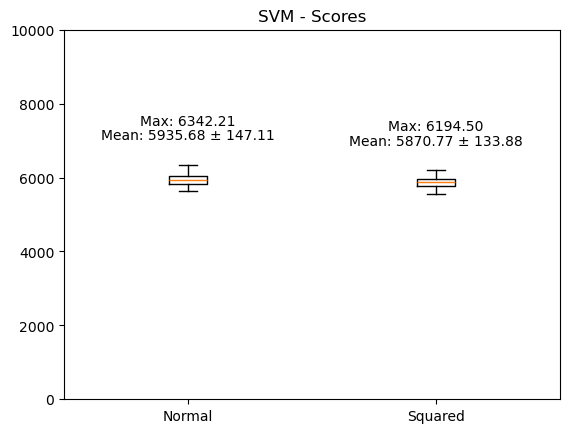

Text(2, 0.838, 'Max: 0.74')

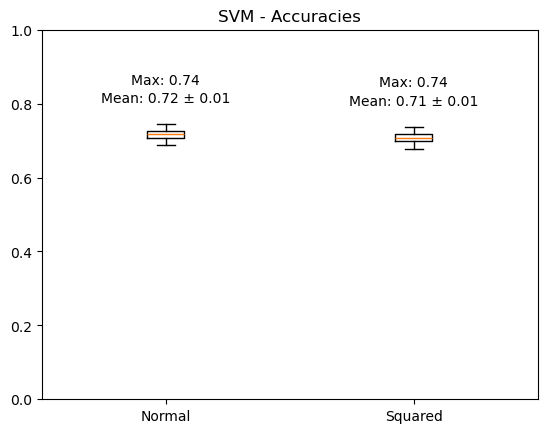

In [15]:
# Boxplot of the results

scores_normal, scores_squared = list(map(lambda x: x.score, normal_results)), list(map(lambda x: x.score, squared_results))
accuracies_normal, accuracies_squared = list(map(lambda x: x.accuracy, normal_results)), list(map(lambda x: x.accuracy, squared_results))

plt.boxplot([scores_normal, scores_squared])
plt.xticks([1, 2], ['Normal', 'Squared'])
plt.ylim(0, 10000)
plt.title('SVM - Scores')

# Mean and max scores on plot
plt.text(1, np.max(scores_normal) + 600, f'Mean: {np.mean(scores_normal):.2f} ± {np.std(scores_normal):.2f}', ha='center', va='bottom')
plt.text(2, np.max(scores_squared) + 600, f'Mean: {np.mean(scores_squared):.2f} ± {np.std(scores_squared):.2f}', ha='center', va='bottom')
plt.text(1, np.max(scores_normal) + 1000, f'Max: {np.max(scores_normal):.2f}', ha='center', va='bottom')
plt.text(2, np.max(scores_squared) + 1000, f'Max: {np.max(scores_squared):.2f}', ha='center', va='bottom')
plt.show()


plt.boxplot([accuracies_normal, accuracies_squared])
plt.xticks([1, 2], ['Normal', 'Squared'])
plt.ylim(0, 1)
plt.title('SVM - Accuracies')

# Mean and max scores on plot
plt.text(1, np.max(accuracies_normal) + 0.05, f'Mean: {np.mean(accuracies_normal):.2f} ± {np.std(accuracies_normal):.2f}', ha='center', va='bottom')
plt.text(2, np.max(accuracies_squared) + 0.05, f'Mean: {np.mean(accuracies_squared):.2f} ± {np.std(accuracies_squared):.2f}', ha='center', va='bottom')
plt.text(1, np.max(accuracies_normal) + 0.1, f'Max: {np.max(accuracies_normal):.2f}', ha='center', va='bottom')
plt.text(2, np.max(accuracies_squared) + 0.1, f'Max: {np.max(accuracies_squared):.2f}', ha='center', va='bottom')

## Apply the model to the final choice - SVM

In [22]:
from aml_projects.Project2.models.utils import GenerateFeatureInteractionsMethod, select_customers, ApplyModelMethod


def apply_model_to_final_choice(
        X: pd.DataFrame,
        y: pd.Series,
        X_test: pd.DataFrame,
        model: ApplyModelMethod,
        generate_feature_interactions: GenerateFeatureInteractionsMethod,
        threshold_num: int,
        random_state: int = 0
) -> pd.Series:
    """
    Apply the  model to the dataset and select the customers.
    :param X: pd.DataFrame - The training dataset.
    :param y: pd.Series - The target variable.
    :param X_test: pd.DataFrame - The test dataset.
    :param model: ApplyModelMethod - The model to apply.
    :param generate_feature_interactions: GenerateFeatureInteractionsMethod - The feature interactions method.
    :param threshold_num: int - The number of customers to select.
    :param random_state: int - The random state.
    :return: pd.Series - The predictions.
    """
    
    X = generate_feature_interactions(X)
    X_test = generate_feature_interactions(X_test)

    predicted_probabilities = model(X, y, X_test, random_state)
    selected_customers = select_customers(predicted_probabilities, threshold_num)
    return selected_customers

In [23]:
from aml_projects.Project2.models.utils import generate_feature_interactions_quadratic

selected_customers = apply_model_to_final_choice(
    X,
    y,
    X_test_submission,
    apply_optimized_svm,
    generate_feature_interactions_quadratic,
    threshold_num=1000
)

selected_features, selected_customers

([100, 101, 102, 103, 104, 105],
 0       False
 1       False
 2       False
 3        True
 4       False
         ...  
 4995     True
 4996     True
 4997    False
 4998    False
 4999    False
 Length: 5000, dtype: bool)

In [24]:
# Save the selected customers indices
selected_customers_indices = selected_customers[selected_customers].index + 1 # Start from 1

# To text file with new line separator
with open('svm_results/selected_customers_indices.txt', 'w') as file:
    file.write('\n'.join(map(str, selected_customers_indices)))

In [25]:
# Save the selected features
selected_features = [feature + 1 for feature in selected_features] # Start from 1
with open('svm_results/selected_features.txt', 'w') as file:
    file.write('\n'.join(map(str, selected_features)))